# Case - Prevendo casos de churn em uma plataforma de streaming

## Introdução

Em uma plataforma de streaming, a diretoria está preocupada com o alto índice de usuários cancelando as suas assinaturas. Eles acreditam que é possível prever se um usuário tem mais chance de deixar a plataforma antes que isso aconteça, e com base nessa informação tomar ações para reduzir o churn. Para realizar tal trabalho, a empresa forneceu uma base de dados em csv contendo dados sobre as contas dos clientes.

## Objetivo do projeto

O objetivo é criar um modelo de classificação utilizando machine learning que seja capaz de prever se um usuário tem mais chance de cancelar a sua assinatura na plataforma ou não.

## Sobre os dados

Os dados fornecidos possuem informações sobre as contas dos clientes na plataforma de streaming, divididos entre contas Basic, Standard e Premium, onde cada uma oferece uma gama maior de serviços que a anterior.

- user_id = Código de identificação do cliente;
- age = Idade do cliente;
- gender = Gênero do cliente;
- time_on_plataform = Dias de assinatura ativa do cliente;
- subscription_type = Tipo de conta;
- avg_rating = Avaliação média dos conteúdos da plataforma;
- num_active_profiles = Número de perfis ativos na plataforma;
- num_streaming_services = Quantidade de serviços de streaming que o cliente possui;
- devices_connected = Quantidade de dispositivos conectados à conta;
- churned = Se o cliente cancelou a conta ou não.

## Bibliotecas utilizadas

Para fazer este projeto foram utilizadas as seguintes bibliotecas do Python,

In [1]:
# libs de análise e manipulação dos dados
import pandas as pd
import numpy as np

# libs de visualização dos dados e análises gráficas
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# libs de machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import LearningCurveDisplay

sns.set_style('darkgrid')   # definindo o estilo escuro do grid dos gráficos do projeto

## Análise dos dados

### Importando os dados

Primeiro, importou-se o dataset "streaming_data.csv", disponível na lista de arquivos deste repositório, utilizando-se a biblioteca Pandas,

In [2]:
pd.set_option('display.max_columns', 50)    # config para mostrar todas as colunas do dataset

streaming = pd.read_csv('streaming_data.csv')
streaming.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,NaN,3,NaN,0.0,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,NaN,1,2.14,0.0,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,1.0,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,NaN,5.0,Basic,NaN,2,NaN,NaN,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
4,18.0,NaN,1948.0,3.0,Basic,NaN,3,3.88,0.0,14879bcb-1977-4ad8-a7f9-6aa9bf7b872f


### Análise Descritiva e Exploratória

Exibindo mais informações a respeito do dataset importado,

In [3]:
streaming.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77884 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     66607 non-null  float64
 1   Gender                  63368 non-null  object 
 2   Time_on_platform        56464 non-null  float64
 3   Devices_connected       52696 non-null  float64
 4   Subscription_type       52663 non-null  object 
 5   Num_streaming_services  9572 non-null   float64
 6   Num_active_profiles     77884 non-null  int64  
 7   Avg_rating              60614 non-null  float64
 8   Churned                 61148 non-null  float64
 9   User_id                 77884 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.9+ MB


Como é possível avaliar acima, tem-se ao todo 77884 entradas, sendo 6 colunas com dados tipo float (números decimais), uma com int (números inteiros) e outras 3 com object(dados tipo texto ou mais de um tipo de dado na mesma coluna).

Outro ponto importante é que diversas das colunas deste dataset não apresentam todas as entradas preenchidas com dados não nulos. Este tratamento de nulos será feito posteriormente neste projeto.

Avaliando-se agora as estatísticas descritivas das colunas numéricas presentes neste dataset,

In [4]:
streaming.describe()

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Churned
count,66607.000000,56464.000000,52696.000000,9572.000000,77884.000000,60614.000000,61148.000000
mean,43.511072,4385.848505,2.995370,2.496239,3.002273,3.002252,0.243066
std,15.043158,2526.580859,1.414072,1.120700,1.413235,1.154963,0.428938
min,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,30.000000,2196.000000,2.000000,1.000000,2.000000,1.990000,0.000000
50%,43.000000,4384.000000,3.000000,2.000000,3.000000,3.010000,0.000000
75%,57.000000,6573.000000,4.000000,4.000000,4.000000,4.000000,0.000000
max,69.000000,8759.000000,5.000000,4.000000,5.000000,5.000000,1.000000


Os resultados foram avaliados abaixo, por coluna.

#### Idade

Tem-se na coluna de idade "Age" um valor máximo de 69 anos, com idade mínima de 18, sendo que 75% dados desta coluna se concentram na faixa de 18 até 57 anos, com idade média de aproximadamente 43 anos. A fim de avaliar esta coluna de forma mais clara, foi plotado abaixo o gráfico de histograma da distribuição destes dados.

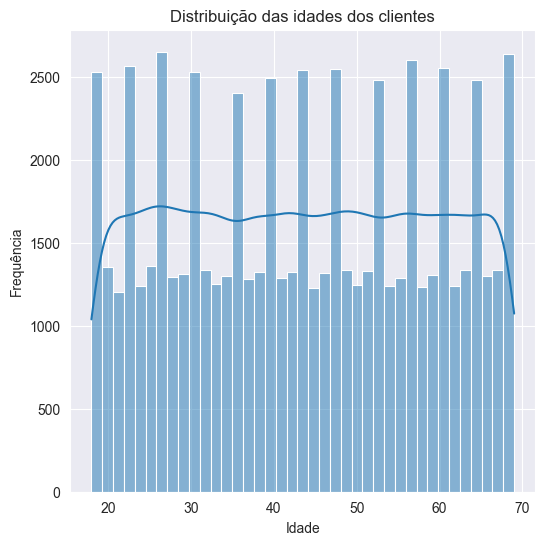

In [5]:
plt.figure(figsize = (6,6))
sns.histplot(
    data = streaming,
    x = 'Age',
    kde = True
)
plt.title('Distribuição das idades dos clientes')
plt.xlabel('Idade')
plt.ylabel('Frequência');

É possível observar um comportamento quase que simétrico dos dados, com uma distribuição homogênea ao longo de todas as idades, sem muito destaque para nenhuma faixa etária. Estamos falando da fase adulta, abrangendo desde pessoas no período universitário, de graduação e início da carreira (20-30 anos) até pessoas que já estão no auge de sua carreia/momento financeiro mais estável (40-60 anos). Isto também demonstra que não existe um público alvo muito marcante na empresa.

#### Tempo de contrato ativo

Para a coluna 'Time_on_platform', observa-se que 75% dos dados tem até 6573 dias de contrato ativo, com 25% dos dados no máximo iguais a 2196 dias. Isto indica que a maior parte destes clientes tem pelo menos 6 anos de contrato, ou seja, percebe-se uma tendência a uma certa fidelização, visto que os contratos também são em média muito longos, com 4385 dias. Abaixo está plotado o histograma destes dados para melhor avaliação,

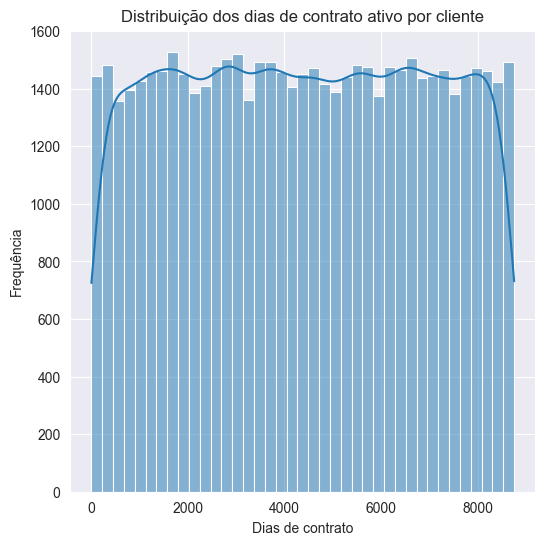

In [6]:
plt.figure(figsize = (6,6))
sns.histplot(
    data = streaming,
    x = 'Time_on_platform',
    kde = True
)
plt.title('Distribuição dos dias de contrato ativo por cliente')
plt.xlabel('Dias de contrato')
plt.ylabel('Frequência');

Observa-se a uma massa bem distribuída de clientes que estão em contrato entre 2000 até mais de 8000 dias.

Contudo, importante destacar que esta é coluna apresenta muitos dados nulos.Logo, esta análise deve ser feita com cautela, considerando que estes dados ao serem tratados, podem passar uma visão diferente desta realidade.

#### Aparelhos conectados

Plotando-se o histograma para a distribuição da quantidade de aparelhos por cliente,

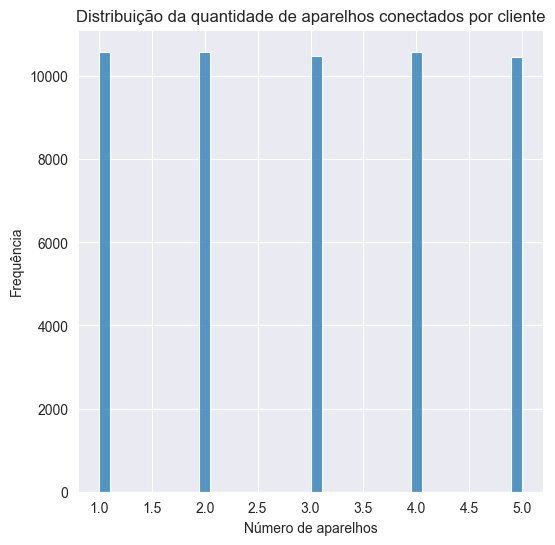

In [7]:
plt.figure(figsize = (6,6))
sns.histplot(
    data = streaming,
    x = 'Devices_connected'
)
plt.title('Distribuição da quantidade de aparelhos conectados por cliente')
plt.xlabel('Número de aparelhos')
plt.ylabel('Frequência');

O resultado do gráfico acima mostra um equilíbrio muito grande no número de aparelhos conectados por cliente, mostrando uma pluralidade de perfis e faixas sociais muito grande entre os clientes da empresa. Isto corrobora fortemente com a análise feita com as faixas etárias anteriormente, onde ficou claro a existência de clientes com 20 até mais de 60 anos.

#### Número de serviços de streaming

Importante observar que a coluna "Num_streaming_services" é a que apresenta a maior quantidade de dados nulos, com apenas 9572 dados não nulos a serem avaliados, número este bem menor do que as 77884 entradas totais do dataset. Plotando-se o histograma desta coluna.

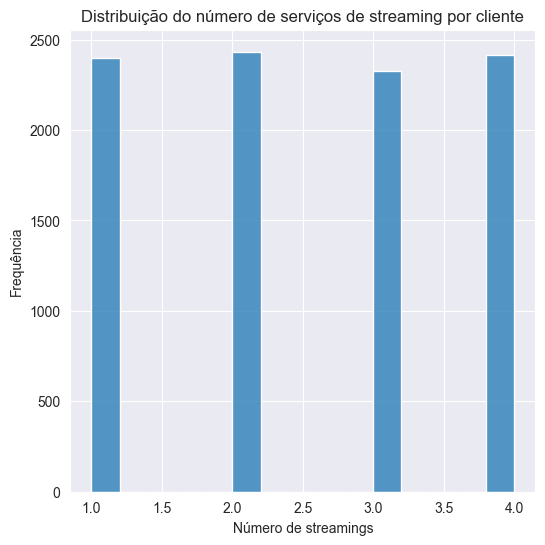

In [8]:
plt.figure(figsize = (6,6))
sns.histplot(
    data = streaming,
    x = 'Num_streaming_services'
)
plt.title('Distribuição do número de serviços de streaming por cliente')
plt.xlabel('Número de streamings')
plt.ylabel('Frequência');

Observa-se uma distribuição muito parelha também na quantidade de serviços de streaming por cliente, com dados praticamente iguais. Também casa com a pluradidade de possíveis configurações familiares para a vasta faixa etária de clientes desta empresa.

Pelo gráfico acima, conforme previsto existem alguns outliers nesta coluna. Como não são muitos, não são provenientes de erros e também não são dados completamente da fora da realidade possível desta coluna (número de serviços de streaming assinados pelo cliente), optou-se por não excluí-los nem fazer qualquer tipo de tratamento ou transformação com eles.

#### Número de perfis ativos no streaming

Avaliando-se agora os dados dos perfis ativos por cliente,

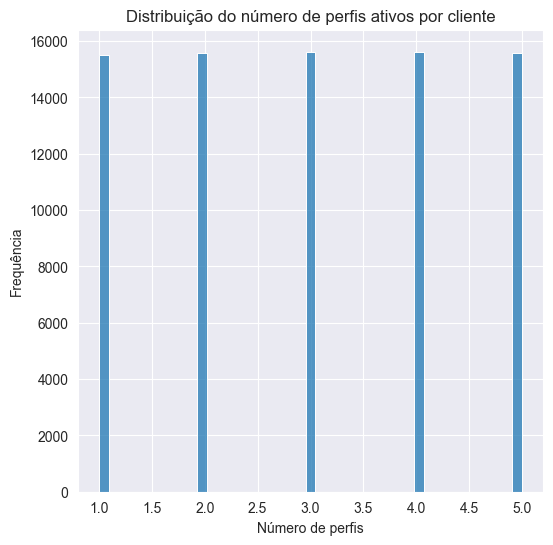

In [9]:
plt.figure(figsize = (6,6))
sns.histplot(
    data = streaming,
    x = 'Num_active_profiles'
)
plt.title('Distribuição do número de perfis ativos por cliente')
plt.xlabel('Número de perfis')
plt.ylabel('Frequência');

Aqui existe um equilíbrio muito grande, com dados praticamente iguais na quantidade de perfis. O que também reforça a tese da distribuição das idades, onde ficou claro que não existe um nicho específico de cliente, abordando diversos tipos de cliente e configurações familiares. Existem tanto clientes que moram com outras pessoas, quanto muitos que são solteiros ou moram sozinhos, e por consequência tem apenas 1 perfil em suas contas.

#### Avaliação média

Analisando-se agora os dados das notas dadas pelos clientes a plataforma,

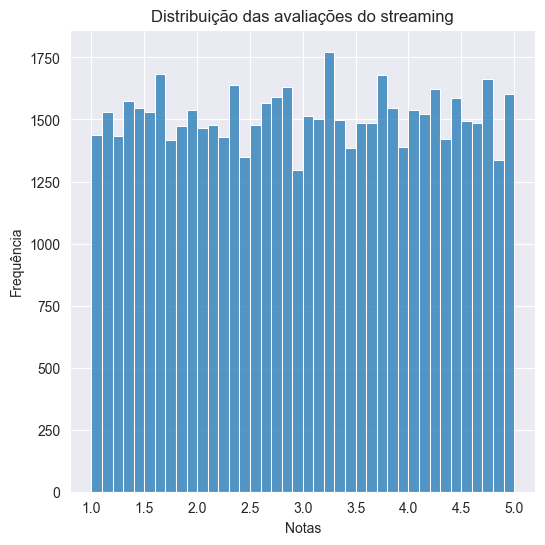

In [10]:
plt.figure(figsize = (6,6))
sns.histplot(
    data = streaming,
    x = 'Avg_rating'
)
plt.title('Distribuição das avaliações do streaming')
plt.xlabel('Notas')
plt.ylabel('Frequência');

Da mesma forma que as demais colunas, aqui também observa-se um equilíbrio muito grande nas avaliações dadas pelos clientes, com uma média das notas igual a 3. Do ponto de vista do negócio, este não é um resultado a ser bem visto pela empresa pois demonstra que as opiniões estão muito dividas com relação aos conteúdos da plataforma, onde o ideal seria uma maior concentração de notas nas faixas mais altas, de 4 a 5.

#### Churned

E por último, avaliando-se a nossa coluna "target" que é a representação da quantidade de churns no dataset. A fim de avaliar isto de forma proporcional, exibindo-se o comparativo dos dados entre clientes que são ou não são churn, optou-se pelo gráfico de pizza abaixo. Importante destacar que, para este caso, suprimiu-se os dados nulos, visto que ainda não foram tratados.

Obs: diferentemente dos gráficos anteriores que foi utilizada a biblioteca Seaborn para plotagem, neste caso utilizou-se da Plotly.

In [11]:
fig = px.pie(
    data_frame = streaming.dropna(),
    names = 'Churned',
    hole = 0.35,
    title = 'Distribuição dos dados de churn'
)

fig.update_layout(
    height = 600,
    width = 600
)

fig

Pelo resultado acima percebe-se que existe uma frequência maior de clientes que não viraram churn (0.0) do que clientes que são churn (1.0). Contudo, é justificável a preocupação do gestor da empresa, pois o percentual de churn está de fato bem aumento, com 26.1% dos dados não nulos.

### Tratando missing_data

Partindo agora para o tratamento dos dados nulos aqui presentes. Primeiro, relembrando as informações gerais do dataset,

In [12]:
streaming.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77884 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     66607 non-null  float64
 1   Gender                  63368 non-null  object 
 2   Time_on_platform        56464 non-null  float64
 3   Devices_connected       52696 non-null  float64
 4   Subscription_type       52663 non-null  object 
 5   Num_streaming_services  9572 non-null   float64
 6   Num_active_profiles     77884 non-null  int64  
 7   Avg_rating              60614 non-null  float64
 8   Churned                 61148 non-null  float64
 9   User_id                 77884 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.9+ MB


Portanto, das 10 colunas do dataset, 8 tem dados nulos. Avaliando-se isto de forma mais aprofundada, posteriormente foi exibida a tabela com as quantidades exatas de dados nulos por coluna e o quanto isto representa do total de entradas presentes. Para tal, primeiro foi definida a função abaixo para calcular e retornar a tabela "missing_data".

In [13]:
# definindo uma função para exibir as informações de dados nulos
def view_missing(df):

  if isinstance(df, pd.core.frame.DataFrame):
    missing_data = (
      df.isnull()
      .sum()
      .to_frame('missing_count')
      .join(((df.isnull().sum())/(df.shape[0])).to_frame('missing_pct'))
    )

    return missing_data.style.format('{:.2%}', subset='missing_pct')

  else:
    return print('O argumento da função precisa ser um Data Frame.')

In [14]:
# aplicando a função definida acima no dataset
view_missing(df = streaming)

,missing_count,missing_pct
Age,11277,14.48%
Gender,14516,18.64%
Time_on_platform,21420,27.50%
Devices_connected,25188,32.34%
Subscription_type,25221,32.38%
Num_streaming_services,68312,87.71%
Num_active_profiles,0,0.00%
Avg_rating,17270,22.17%
Churned,16736,21.49%
User_id,0,0.00%


A maior quantidade está na coluna "Num_streaming_services" com praticamente 88% dos dados sendo nulos. Nas demais colunas, exceto "Num_active_profiles" e "User_id", também existem quantidades expressivas de dados nulos, com faixas variando de 14 até 32%.

Para fins de resolução deste case, assumiu-se que os dados nulos provenientes das colunas "Time_on_plataform", "Num_streaming_services", "Churned", "Avg_rating" e "Devices_connected" serão substituídos pelo número 0, conforme demonstrado a seguir.

In [15]:
lista = ['Time_on_platform', 'Num_streaming_services', 'Churned', 'Avg_rating', 'Devices_connected']

for coluna in streaming[lista].columns:
  streaming[coluna].fillna(0, inplace = True)

Já para as colunas "Gender", "Age" e "Subscription_type", as linhas com dados nulos foram excluídas do dataset. Como os demais dados nulos das outras colunas já foram substituídos, basta excluir os restantes.

In [16]:
streaming.dropna(inplace = True)

Exibindo-se a nova configuração do dataset,

In [17]:
view_missing(df = streaming)

,missing_count,missing_pct
Age,0,0.00%
Gender,0,0.00%
Time_on_platform,0,0.00%
Devices_connected,0,0.00%
Subscription_type,0,0.00%
Num_streaming_services,0,0.00%
Num_active_profiles,0,0.00%
Avg_rating,0,0.00%
Churned,0,0.00%
User_id,0,0.00%


Portanto, agora não temos mais nenhum dado nulo no dataset.

### Linhas duplicadas

Verificando-se a existência de linhas duplicadas:

In [18]:
streaming.duplicated().sum()

5776

Portanto existem 5776 linhas duplicadas neste dataset. Exibindo-se algumas delas,

In [19]:
streaming[streaming.duplicated(keep = False)]

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
3,26.0,Male,0.0,5.0,Basic,0.0,2,0.00,0.0,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
20,20.0,Male,2542.0,5.0,Basic,0.0,1,0.00,1.0,b4da071a-c8b4-44dd-84fb-7de32abf766f
25,63.0,Female,249.0,2.0,Standard,4.0,5,2.29,0.0,44879a07-a820-4316-a6d1-ddc14c9b8ab1
53,41.0,Male,6239.0,5.0,Standard,0.0,2,0.00,0.0,66700e8a-d213-495a-bd89-bd4c8d5ad25c
73,51.0,Female,5815.0,0.0,Standard,0.0,4,0.00,0.0,d3839320-88cb-4dc6-a712-3fbcd1ffae55
...,...,...,...,...,...,...,...,...,...,...
77879,45.0,Male,0.0,0.0,Basic,0.0,5,2.20,0.0,6b51fe0d-d4a1-41ed-a55c-d05f5c961e3c
77880,47.0,Female,6176.0,0.0,Premium,0.0,2,4.54,0.0,59d70167-6be0-474c-b71e-14153205b44f
77881,64.0,Female,0.0,5.0,Premium,0.0,1,4.34,1.0,a7d5ed26-78a4-4e70-bd04-0fec883e56aa
77882,58.0,Male,1314.0,5.0,Standard,0.0,4,0.00,0.0,472e9e70-87ca-4c5e-bfee-fa9f42b54f51


Avaliando em separado alguns destes casos,

In [20]:
streaming[streaming['User_id'] == 'c316f2f5-3403-4a0a-82c2-c98e4b3379d2']

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
3,26.0,Male,0.0,5.0,Basic,0.0,2,0.0,0.0,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
70876,26.0,Male,0.0,5.0,Basic,0.0,2,0.0,0.0,c316f2f5-3403-4a0a-82c2-c98e4b3379d2


In [21]:
streaming[streaming['User_id'] == 'b4da071a-c8b4-44dd-84fb-7de32abf766f']

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
20,20.0,Male,2542.0,5.0,Basic,0.0,1,0.0,1.0,b4da071a-c8b4-44dd-84fb-7de32abf766f
69324,20.0,Male,2542.0,5.0,Basic,0.0,1,0.0,1.0,b4da071a-c8b4-44dd-84fb-7de32abf766f


Conforme os resultados acima, fica claro que existem alguns clientes registrados duas vezes, apresentando linhas no dataset com dados exatamente iguais, até o "User_id" que é um valor único por cliente. Logo, é conveniente e acertivo eliminar estas linhas duplicadas, de forma a aparecer tais clientes apenas uma vez na base de dados.

In [22]:
streaming.drop_duplicates(inplace = True)

Verificando-se agora a quantidade de dados duplicados,

In [23]:
streaming.duplicated().sum()

0

Desta forma, todas as linhas duplicadas foram devidamente excluídas do dataset.

### Tratando o tipo dos dados de cada coluna

Observando agora a nova "cara" do dataset, sem as linhas duplicadas e com os dados nulos já devidamente tratados,

In [24]:
streaming.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30739 entries, 0 to 65479
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     30739 non-null  float64
 1   Gender                  30739 non-null  object 
 2   Time_on_platform        30739 non-null  float64
 3   Devices_connected       30739 non-null  float64
 4   Subscription_type       30739 non-null  object 
 5   Num_streaming_services  30739 non-null  float64
 6   Num_active_profiles     30739 non-null  int64  
 7   Avg_rating              30739 non-null  float64
 8   Churned                 30739 non-null  float64
 9   User_id                 30739 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 2.6+ MB


O que antes eram 77884 entradas, agora são "apenas" 30739, com todas as colunas preenchidas com dados não nulos e nenhuma linha duplicada.

Agora, é relevante avaliar se o tipo dos dados de cada coluna corresponde a informação que tal coluna retorna. Por exemplo, a coluna "Age" se trata das idades de cada cliente. Contudo, os dados desta coluna estão do tipo float, ou seja, números decimais. Não faz sentido representar uma idade com número decimal, logo este é um caso em que será necessário convertê-los para números inteiros.

Esta análise também pode ser feita para as colunas "Time_on_platform", "Devices_connected" e "Num_streaming_services", onde as informações são referentes respectivamente a dias de assinatura ativa do cliente, quantidade de dispositivos conectados e o número de serviços de streaming. Portanto, deveriam ser todos dados numéricos inteiros, e não números decimais.

Outro caso a ser observado é da coluna "Churned", onde tem-se entradas 1.0 e 0.0, onde 1.0 = cliente que virou churn e 0.0 = cliente não churn. Como são dados que representam na prática "sim" ou "não", também optou-se por alterá-los para números inteiros 1 e 0.

Desta forma, todas estas colunas citadas foram tratadas, conforme demonstrado abaixo.

In [25]:
for coluna in streaming.select_dtypes('number').columns:
  if streaming[coluna].dtype != 'int' and coluna != 'Avg_rating':
    streaming[coluna] = streaming[coluna].astype('int')

Exibindo-se os novos tipos de dados das colunas,

In [26]:
streaming.dtypes

Age                         int32
Gender                     object
Time_on_platform            int32
Devices_connected           int32
Subscription_type          object
Num_streaming_services      int32
Num_active_profiles         int32
Avg_rating                float64
Churned                     int32
User_id                    object
dtype: object

Agora sim os tipos de dados estão coerentes as informações das colunas.

## Modelling

Com os dados devidamente tratados, agora é possível partir para o processo de definição do modelo de machine learning. Recapitulando o objetivo deste projeto, o modelo precisa prever se um usuário tem chance de cancelar a sua assinatura na plataforma. Desta forma, o foco aqui é calcular se o cliente irá se tornar churn ou não.

### Separando as variáveis em grupos: features e target

Conforme explicado acima, antes de definir o modelo de fato é necessária esta separação das variáveis em dois grupos:

* features = grupo das colunas explicativas, ou seja, que explicam a nossa variável target;

* target = variável objetivo, o que se deseja prever com o modelo.

Portanto, reitera-se que a coluna "target" é a "Churned", sendo todas as demais, exceto "User_id" (só apresenta os códigos dos clientes), colunas "features" que ajudam a explicar o comportamento do nosso target.

In [27]:
x = streaming.drop(columns = ['User_id', 'Churned'])  # features
y = streaming[['Churned']]                            # target

In [28]:
x.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating
0,49,Male,4700,3,Basic,0,3,0.00
1,69,Female,6107,2,Standard,0,1,2.14
2,44,Male,6374,3,Premium,1,1,1.91
3,26,Male,0,5,Basic,0,2,0.00
5,54,Male,3024,2,Basic,0,1,0.00


In [29]:
y.head()

,Churned
0,0
1,0
2,1
3,0
5,0


### Tratando as features

#### Features categóricas